# load_data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/My\ Drive/Colab\ Notebooks/datasets/jena_climate_2009_2016.csv.zip

Archive:  /content/drive/My Drive/Colab Notebooks/datasets/jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [ ]:
f = open('jena_climate_2009_2016.csv')
data = f.read()
f.close()
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [ ]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i,:] = values

In [ ]:
line.split(',')[1:]

['999.82',
 '-4.82',
 '268.36',
 '-8.42',
 '75.70',
 '4.27',
 '3.23',
 '1.04',
 '2.01',
 '3.23',
 '1296.38',
 '1.23',
 '1.96',
 '184.90']

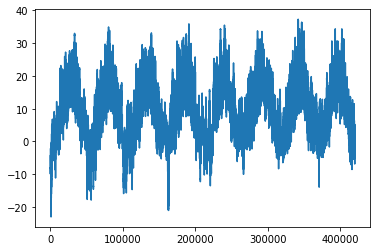

In [ ]:
from matplotlib import pyplot as plt

temp = float_data[:,1]
plt.plot(range(len(temp)), temp)

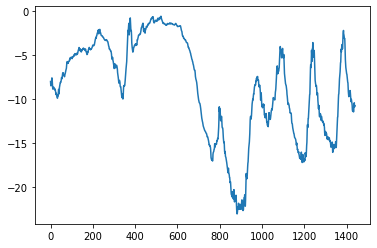

In [ ]:
plt.plot(range(1440), temp[:1440])

In [ ]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /=std

In [ ]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np. random.randint(min_index + lookback, max_index, size = batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.range(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                            lookback // step,
                            data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [ ]:
lookback = 1440
step = 6
delay = 144
batch_size = 128
train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)
val_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=200001,
                      max_index=300000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)
test_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=300001,
                      max_index=None,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)

val_steps = (300000-200001-lookback) // batch_size

test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [ ]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))

In [ ]:
evaluate_naive_method()

0.28786635214632705


In [ ]:
0.29 *std[1]

2.5672247338393395

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_gen,
                    steps_per_epoch=500,
                    epochs=20,
                    validation_data=val_gen,
                    validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 20s 35ms/step - loss: 1.5456 - val_loss: 0.7940
Epoch 2/20
500/500 [==============================] - 15s 29ms/step - loss: 0.5189 - val_loss: 0.4004
Epoch 3/20
500/500 [==============================] - 14s 29ms/step - loss: 0.3064 - val_loss: 0.3234
Epoch 4/20
500/500 [==============================] - 17s 34ms/step - loss: 0.2701 - val_loss: 0.3074
Epoch 5/20
500/500 [==============================] - 14s 29ms/step - loss: 0.2547 - val_loss: 0.3505
Epoch 6/20
500/500 [==============================] - 17s 34ms/step - loss: 0.2452 - val_loss: 0.3169
Epoch 7/20
500/500 [==============================] - 17s 34ms/step - loss: 0.2387 - val_loss: 0.3185
Epoch 8/20
500/500 [==============================] - 17s 34ms/step - loss: 0.2315 - val_loss: 0.3243
Epoch 9/20
500/500 [==============================] - 17s 34ms/step - loss: 0.2274 - val_loss: 0.3251
Epoch 10/20
500/500 [==============================] - 15s 29ms/step - loss: 0.223

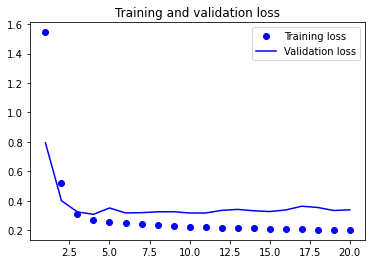

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# RNN

## base

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss = 'mae')
history = model.fit(train_gen,
                    steps_per_epoch=500,
                    epochs=20,
                    validation_data=val_gen,
                    validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 38s 67ms/step - loss: 0.3141 - val_loss: 0.2693
Epoch 2/20
500/500 [==============================] - 33s 66ms/step - loss: 0.2832 - val_loss: 0.2643
Epoch 3/20
500/500 [==============================] - 33s 66ms/step - loss: 0.2766 - val_loss: 0.2659
Epoch 4/20
500/500 [==============================] - 33s 65ms/step - loss: 0.2712 - val_loss: 0.2659
Epoch 5/20
500/500 [==============================] - 33s 65ms/step - loss: 0.2664 - val_loss: 0.2648
Epoch 6/20
500/500 [==============================] - 33s 66ms/step - loss: 0.2614 - val_loss: 0.2613
Epoch 7/20
500/500 [==============================] - 33s 66ms/step - loss: 0.2579 - val_loss: 0.2619
Epoch 8/20
500/500 [==============================] - 32s 65ms/step - loss: 0.2532 - val_loss: 0.2638
Epoch 9/20
500/500 [==============================] - 33s 65ms/step - loss: 0.2483 - val_loss: 0.2683
Epoch 10/20
500/500 [==============================] - 33s 66ms/step - loss: 0.241

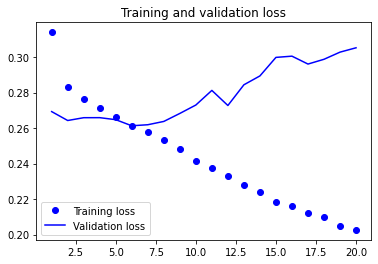

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## dropout

The requirements to use the cuDNN implementation are:

- activation == tanh
- recurrent_activation == sigmoid
- recurrent_dropout == 0
- unroll is False
- use_bias is True
- Inputs, if use masking, are strictly right-padded.
- Eager execution is enabled in the outermost context.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss = 'mae')
history = model.fit(train_gen,
                    steps_per_epoch=500,
                    epochs=40,
                    validation_data=val_gen,
                    validation_steps=val_steps)

Epoch 1/40
246/500 [=============>................] - ETA: 4:15 - loss: 0.3355

KeyboardInterrupt: ignored

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## stacking

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1,
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss = 'mae')
history = model.fit(train_gen,
                    steps_per_epoch=500,
                    epochs=40,
                    validation_data=val_gen,
                    validation_steps=val_steps)

Epoch 1/40


KeyboardInterrupt: ignored

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## bidirectional

### IMDB 자연어 문제

시계열 데이터와 다르게 자연어는 시간 순서대로 처리하는 것과 순서를 뒤집는 것이 거의 동일하게 잘 작동한다. p.296

In [ ]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

max_features = 10000
maxlen = 500

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words = max_features)

x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]

x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

17473536/17464789 [==============================] - 0s 0us/step
Epoch 1/10
157/157 [==============================] - 14s 74ms/step - loss: 0.4890 - acc: 0.7678 - val_loss: 0.6038 - val_acc: 0.7616
Epoch 2/10
157/157 [==============================] - 11s 67ms/step - loss: 0.3149 - acc: 0.8803 - val_loss: 0.3298 - val_acc: 0.8812
Epoch 3/10
157/157 [==============================] - 11s 67ms/step - loss: 0.2531 - acc: 0.9075 - val_loss: 0.3474 - val_acc: 0.8536
Epoch 4/10
157/157 [==============================] - 11s 67ms/step - loss: 0.2137 - acc: 0.9258 - val_loss: 0.3318 - val_acc: 0.8652
Epoch 5/10
157/157 [==============================] - 11s 67ms/step - loss: 0.1950 - acc: 0.9301 - val_loss: 0.4824 - val_acc: 0.8038
Epoch 6/10
157/157 [==============================] - 11s 67ms/step - loss: 0.1840 - acc: 0.9384 - val_loss: 0.4242 - val_acc: 0.8468
Epoch 7/10
157/157 [==============================] - 10s 67ms/step - loss: 0.1613 - acc: 0.9470 - val_loss: 0.3957 - val_acc: 0.87

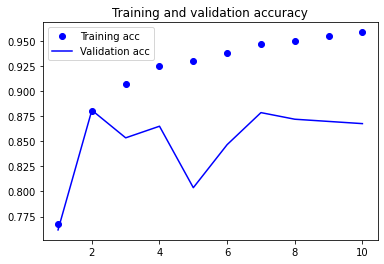

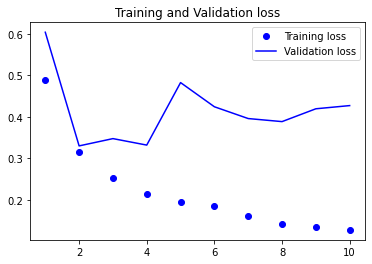

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

In [ ]:
model=Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 34s 192ms/step - loss: 0.6036 - acc: 0.6779 - val_loss: 0.5827 - val_acc: 0.6858
Epoch 2/10
157/157 [==============================] - 29s 186ms/step - loss: 0.3788 - acc: 0.8483 - val_loss: 0.3247 - val_acc: 0.8782
Epoch 3/10
157/157 [==============================] - 29s 186ms/step - loss: 0.2883 - acc: 0.8917 - val_loss: 0.3857 - val_acc: 0.8664
Epoch 4/10
157/157 [==============================] - 29s 186ms/step - loss: 0.2394 - acc: 0.9111 - val_loss: 0.4535 - val_acc: 0.8534
Epoch 5/10
157/157 [==============================] - 29s 186ms/step - loss: 0.2173 - acc: 0.9227 - val_loss: 0.3338 - val_acc: 0.8732
Epoch 6/10
157/157 [==============================] - 29s 186ms/step - loss: 0.1889 - acc: 0.9327 - val_loss: 0.3441 - val_acc: 0.8666
Epoch 7/10
157/157 [==============================] - 29s 186ms/step - loss: 0.1684 - acc: 0.9412 - val_loss: 0.3697 - val_acc: 0.8820
Epoch 8/10
157/157 [==============================] - 2

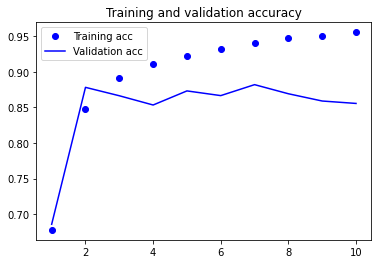

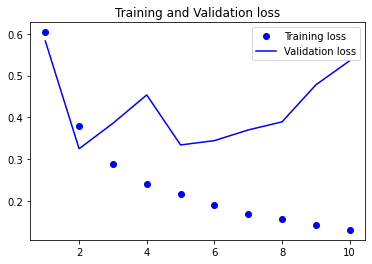

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

### 시계열

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Bidirectional(layers.GRU(32),
                               input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss = 'mae')
history = model.fit(train_gen,
                    steps_per_epoch=500,
                    epochs=10,
                    validation_data=val_gen,
                    validation_steps=val_steps)

Epoch 1/10
500/500 [==============================] - 71s 135ms/step - loss: 0.2951 - val_loss: 0.2707
Epoch 2/10
500/500 [==============================] - 67s 134ms/step - loss: 0.2773 - val_loss: 0.2661
Epoch 3/10
500/500 [==============================] - 67s 134ms/step - loss: 0.2694 - val_loss: 0.2689
Epoch 4/10
500/500 [==============================] - 67s 133ms/step - loss: 0.2659 - val_loss: 0.2724
Epoch 5/10
500/500 [==============================] - 67s 134ms/step - loss: 0.2598 - val_loss: 0.2638
Epoch 6/10
500/500 [==============================] - 67s 134ms/step - loss: 0.2554 - val_loss: 0.2650
Epoch 7/10
500/500 [==============================] - 67s 134ms/step - loss: 0.2496 - val_loss: 0.2685
Epoch 8/10
500/500 [==============================] - 67s 134ms/step - loss: 0.2425 - val_loss: 0.2749
Epoch 9/10
500/500 [==============================] - 67s 134ms/step - loss: 0.2385 - val_loss: 0.2793
Epoch 10/10
500/500 [==============================] - 67s 133ms/step - l

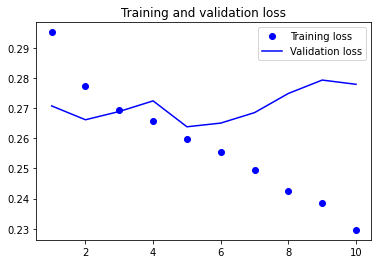

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

일반 GRU 층과 비슷한 성능을 낸다. 이유는 모든 예측 성능이 시간 순서대로 처리하는 신경망에서 오기 때문. p.298